<a href="https://colab.research.google.com/github/achett/Hierarchical-Model/blob/main/Revenue_FY23_Blind_Test_Enhancements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install hierarchicalforecast
# !pip install statsforecast
# !pip install datasetsforecast
# !pip install nixtlats>=0.1.0
# !pip install darts
# !pip install mlforecast

In [3]:
########################
# PACKAGES
########################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
from functools import reduce
from dateutil.relativedelta import relativedelta

# from statsforecast.core import StatsForecast
# from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoCES, AutoTheta
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder

# from hierarchicalforecast.core import HierarchicalReconciliation
# from hierarchicalforecast.evaluation import HierarchicalEvaluation
# from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, OptimalCombination, ERM, PERMBU, Bootstrap, Normality
# from hierarchicalforecast.utils import aggregate
# from nixtlats import TimeGPT
# os.environ['NIXTLA_ID_AS_COL'] = '1'


# from darts import TimeSeries, concatenate
# from darts.models import RegressionModel, LightGBMModel, ExponentialSmoothing, StatsForecastAutoETS, StatsForecastAutoARIMA, KalmanForecaster
# from darts.dataprocessing.transformers import Scaler
# from lightgbm import LGBMRegressor
# from darts.metrics import mae, rmse, mape, mql, mse, ope
# from darts.utils.likelihood_models import QuantileRegression

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
##############
# PARAMS
##############
fct_periods = 15
fct_st_date = '2023-04-01'
fct_end_date = '2024-03-01'

# Create hierarchical structure and constraints
hierarchy_levels = [['TopLv'],
                    ['TopLv', 'ProductLv'],
                    ['TopLv', 'ProductLv', 'Lv1'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5']]

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/regional_hierarchy.xlsx'
sheet_name = 'regional_hierarchy v2'
r_hier = pd.read_excel(inputFile, sheet_name=sheet_name)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/model_selection.xlsx'
model_selection = pd.read_excel(inputFile)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/Product Naming Convention.xlsx'
product_naming_convention = pd.read_excel(inputFile)

In [5]:
##############
# FUNCTIONS
##############
def prepare_data(data, r_hier):

    # Merge hierarchy
    data = data.merge(r_hier, how='inner', left_on='cost_object', right_on='Lv5')

    # Transform date and y
    data['ds'] = pd.to_datetime(data['ds'])
    data['y'] = data['y'].astype(float)

    # Address NA values
    data['y'] = data['y'].fillna(0)
    data['TopLv'] = data['TopLv'].fillna('')
    data['Lv1'] = data['Lv1'].fillna('')
    data['Lv2'] = data['Lv2'].fillna('')
    data['Lv3'] = data['Lv3'].fillna('')
    data['Lv4'] = data['Lv4'].fillna('')
    data['Lv5'] = data['Lv5'].fillna('')
    data['product'] = data['product'].fillna('')

    # Create hierarchical dataframe
    data.rename(columns={'product': 'ProductLv'}, inplace=True)
    data = data[['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'y']]

    # Replace '/' with '_' in the four columns
    data['TopLv'] = data['TopLv'].str.replace('/', '_')
    data['ProductLv'] = data['ProductLv'].str.replace('/', '_')
    data['Lv1'] = data['Lv1'].str.replace('/', '_')
    data['Lv2'] = data['Lv2'].str.replace('/', '_')
    data['Lv3'] = data['Lv3'].str.replace('/', '_')
    data['Lv4'] = data['Lv4'].str.replace('/', '_')
    data['Lv5'] = data['Lv5'].str.replace('/', '_')

    data['unique_id'] = data['TopLv'] + '/' + data['ProductLv'] + '/' + data['Lv1'] + '/' + data['Lv2'] + '/' + data['Lv3'] + '/' + data['Lv4'] + '/' + data['Lv5']

    # Assuming df is your existing DataFrame
    grouping_columns = ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'unique_id']  # All columns except 'y'

    # Group by specified columns and sum 'y'
    data = data.groupby(grouping_columns)['y'].sum().reset_index()

    return data

def prepare_feature(data, r_hier, volume_act2, feature_name):

    # Select and rename columns
    data = data[['cost_object', 'product', 'ds', feature_name]].rename(columns={feature_name: 'y'})

    # Apply any additional preparation (assuming prepare_data is a function you have defined)
    data = prepare_data(data, r_hier)

    # Rename the columns back
    data = data.rename(columns={'y': feature_name})

    # Merge with the volume_act2 dataframe
    merged_df = data.merge(volume_act2[['unique_id', 'ds']], how='right', on=['unique_id', 'ds'])

    return merged_df


In [6]:
##############
# DATA LOAD
##############
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23.csv'
budget = pd.read_csv(inputFile)
# budget = budget[budget['category']=='EQUIV_UNIT - Equivalent Units']
budget = budget[budget['category']=='UC110000 - Total Revenue']
budget.rename(columns={'country': 'cost_object'}, inplace=True)
budget = prepare_data(budget, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/revenue_output.csv'
volume_act = pd.read_csv(inputFile)
volume_act.rename(columns={'value': 'y'}, inplace=True)
volume_act = prepare_data(volume_act, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)

sga1 = prepare_feature(sga, r_hier, volume_act, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act, 'Field_Sales')

In [7]:
########################
# IDENTIFY UNIVERSE
########################
tested_ts = set(budget['unique_id'].unique()).intersection(volume_act['unique_id'].unique())

# Find unique IDs present in budget_h but not in rev
unique_ids_in_budget_not_in_rev = set(budget['unique_id'].unique()).difference(volume_act['unique_id'].unique())

# Find unique IDs present in rev but not in budget_h
unique_ids_in_rev_not_in_budget = set(volume_act['unique_id'].unique()).difference(budget['unique_id'].unique())

# Filter volume
volume_act = volume_act[volume_act['unique_id'].isin(tested_ts)]

In [8]:
########################
# SEGMENT TIME SERIES
########################
new_products = ['ENFORTUMAB - Enforumab Vedotin', 'ROXADUSTNT - Roxadustant']
loe_products = ['REGADENOSN - Regadenoson']
div_products = ['MICAFUNGIN - Micafungin Sodium']

new_ids = volume_act[volume_act['ProductLv'].isin(new_products)]['unique_id'].unique().tolist()
loe_ids = volume_act[volume_act['ProductLv'].isin(loe_products)]['unique_id'].unique().tolist()
divested_ids = volume_act[volume_act['ProductLv'].isin(div_products)]['unique_id'].unique().tolist()

# IDs with A&P and Field Sales Spend
grouped1 = sga1.groupby('unique_id')[['AP']].sum()
grouped2 = sga2.groupby('unique_id')[['Field_Sales']].sum()
spend_ids = set(grouped1[(grouped1['AP'] > 0)].index.tolist() + grouped2[(grouped2['Field_Sales'] > 0)].index.tolist())
spend_ids = spend_ids.difference(new_ids + loe_ids + divested_ids)

# IDs with no spend
non_spend_ids = volume_act[~volume_act['unique_id'].isin(spend_ids)]['unique_id'].unique()

# Model Selection
arima_regions = model_selection[model_selection['model']=='ARIMA']['Lv3'].unique()
ets_regions = model_selection[model_selection['model']=='ETS']['Lv3'].unique()
# arima_ids = volume_act[(volume_act['level3'].isin(arima_regions)) & (~volume_act['unique_id'].isin(spend_ids))]['unique_id'].unique().tolist()
# ets_ids = volume_act[(volume_act['level3'].isin(ets_regions)) & (~volume_act['unique_id'].isin(spend_ids))]['unique_id'].unique().tolist()

arima_ids = volume_act[(volume_act['Lv3'].isin(arima_regions))]['unique_id'].unique().tolist()
ets_ids = volume_act[(volume_act['Lv3'].isin(ets_regions))]['unique_id'].unique().tolist()

# Solifenacin _ Tamsulosin
solif_tams_ids = volume_act[volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin', 'TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique().tolist()
arima_ids = set(arima_ids+solif_tams_ids)
ets_ids = [id for id in ets_ids if id not in solif_tams_ids]

In [9]:
########################
# DATA CONVERSION
########################
set2zero_list=['Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_BELGIUM - Belgium/D_E_BELGIUM - Belgium',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_CZECH - Czech',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_HUBGROGR - HBRG/D_E_HUBGRO - Hungary  Bulgaria & Romania/D_E_HU - Hungary',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_IE - Ireland/D_E_IE - Ireland/D_E_IE - Ireland',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_MTCYIS - Malta  Cyprus & Iceland/D_E_MALTA - Malta',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_NORDIC - Nordic/D_E_NORWAY - Norway/D_E_NORWAY - Norway',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_REST - Domestic Rest of Latam/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_SINMAL - SINMAL/D_I_SINGAPORE - SINGAPORE/D_I_SINGAPORE - SINGAPORE',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
      'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_NETHLND - Netherlands/D_E_NETHLND - Netherlands',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_DB - Domestic Latam Distributor Business/D_I_AR - Domestic Argentina/D_I_AR - Domestic Argentina',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan']

volume_act.loc[(volume_act['unique_id'].isin(set2zero_list)) & (volume_act['ds'] < '2022-04-01'), 'y'] = 0

# **ORIGINAL RUN**

In [10]:
########################
# SAMPLE
########################
# ts2fix = ['Global/ROMOSOZUMA - ROMOSOZUMA/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc', 'Global/MIRABEGRON - Mirabegron/D_E_ESTMKT - Established Markets/D_E_CA - Canada/D_E_CA - Canada/D_E_CA - Canada/D_E_CA - Canada',
#           'Global/MIRABEGRON - Mirabegron/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.', 'Global/ENZA - Enzalutamide/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.',
#           'Global/ENZA - Enzalutamide/D_E_ESTMKT - Established Markets/D_E_DE - Germany/D_E_DE - Germany/D_E_DE - Germany/D_E_DE - Germany', 'Global/ENZA - Enzalutamide/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc',
#           'Global/ENZA - Enzalutamide/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia']

# volume_act = volume_act[volume_act['unique_id'].isin(ts2fix)]


In [11]:
########################
# RUN ETS & ARIMA
########################
# def convert_fct2df(forecasts):
#     forecast_dfs = []
#     for unique_id, forecast_ts in forecasts.items():
#         df = TimeSeries.quantiles_df(forecast_ts, quantiles=[0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995])
#         df['unique_id'] = unique_id
#         df = df.reset_index()
#         df = df.rename(columns={'y_0.5': 'y'})
#         forecast_dfs.append(df)

#     # Concatenate all forecast DataFrames into a single DataFrame
#     all_forecasts_df = pd.concat(forecast_dfs, axis=0)

#     # Reorder and rename columns as needed
#     columns = ['unique_id'] + [col for col in all_forecasts_df.columns if col != 'unique_id']
#     all_forecasts_df = all_forecasts_df[columns]

#     all_forecasts_df.columns.name = None

#     return all_forecasts_df

# def generate_time_series_dict(data, fct_periods, filter_data):
#     # Split train/test sets
#     test = data.groupby('unique_id').tail(fct_periods)
#     train = data.drop(test.index)

#     # Prepare time series dataframes
#     time_series_dfs = {uid: group for uid, group in train.groupby('unique_id')}
#     time_series_dict = {}

#     if filter_data:
#         # Filter out time series with insufficient non-zero data points
#         filtered_time_series_dfs = {}
#         for uid, group in time_series_dfs.items():
#             non_zero_index = group['y'].ne(0).idxmax()
#             start_index = max(0, non_zero_index - (13 - 1))
#             filtered_df = group.loc[non_zero_index:] if group.loc[non_zero_index:].shape[0] >= 13 else group.loc[start_index:]
#             if not filtered_df.empty:
#                 filtered_time_series_dfs[uid] = filtered_df
#         # Convert each filtered DataFrame into a Darts TimeSeries object

#         time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in filtered_time_series_dfs.items()}
#     else:
#         # Convert each original DataFrame into a Darts TimeSeries object without filtering
#         time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in time_series_dfs.items()}

#     return time_series_dict

# def generate_forecast(data, fct_periods, model2use, filter_data=True):

#     # Use the nested function to generate the time series dictionary
#     time_series_dict = generate_time_series_dict(data, fct_periods, filter_data)

#     # Create and fit a model for each time series
#     models = {}
#     for uid, series in time_series_dict.items():
#         model = get_model(model2use)
#         model.fit(series)
#         models[uid] = model

#     # Forecasting
#     fct_dict = {uid: model.predict(fct_periods, num_samples=1000) for uid, model in models.items()}

#     # Convert forecasts into a dataframe
#     fct_df = convert_fct2df(fct_dict)
#     print('hi')
#     return fct_dict, fct_df

# # Function to dynamically get the model instance
# def get_model(model_name):
#     if model_name == 'AutoETS':
#         return StatsForecastAutoETS()
#     elif model_name == 'ARIMA':
#         return StatsForecastAutoARIMA(season_length=12)
#     elif model_name == 'KF':
#         return KalmanForecaster(dim_x=12)
#     else:
#         raise ValueError(f"Unsupported model: {model_name}")

# # q = volume_act[volume_act['unique_id']=='Global/AMPHOTERCN - Amphotericin B/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.']

# # Check if 'ets_ids' list has values before running 'AutoETS' model
# if ets_ids:
#     ets_filtered_data = volume_act[volume_act['unique_id'].isin(ets_ids)]
#     if not ets_filtered_data.empty:  # Also check if the filtered DataFrame is not empty
#         ets_dict, ets_df = generate_forecast(ets_filtered_data, fct_periods, model2use='AutoETS', filter_data=True)

# # Check if 'arima_ids' list has values before running 'ARIMA' model
# if arima_ids:
#     arima_filtered_data = volume_act[volume_act['unique_id'].isin(arima_ids)]
#     if not arima_filtered_data.empty:  # Also check if the filtered DataFrame is not empty
#         arima_dict, arima_df = generate_forecast(arima_filtered_data, fct_periods, model2use='ARIMA', filter_data=True)

# # You can uncomment the following line if you want to always run 'KF' model regardless of filtering
# # kf_fct = generate_forecast(volume_act, fct_periods, model2use='KF', filter_data=True)



In [12]:
########################
# XTREND - DECAY
########################
# import pandas as pd
# from dateutil.relativedelta import relativedelta
# import numpy as np

# def apply_exponential_decay(df, start_date, end_date, end_value_percentage, target_unique_ids):

#     # Convert 'ds' to datetime if it's not already and sort
#     df['ds'] = pd.to_datetime(df['ds'])
#     df = df.sort_values(by='ds')
#     start_date = pd.to_datetime(start_date)
#     end_date = pd.to_datetime(end_date)

#     # Loop through each group (unique_id)
#     for unique_id in target_unique_ids:
#         group = df[df['unique_id'] == unique_id]

#         # Columns to apply decay to
#         decay_columns = [col for col in group.columns if col not in ['unique_id', 'ds']]

#         # Initialize a dictionary to keep the end values for each decay column
#         end_values = {}

#         # Find start and end values and dates for each column
#         for col in decay_columns:
#             if start_date in group['ds'].values and end_date in group['ds'].values:
#                 start_value = group.loc[group['ds'] == start_date, col].iloc[0]
#                 end_value = start_value * end_value_percentage
#                 end_values[col] = end_value  # Store the end value for this column

#                 # Calculate the decay rate based on exponential decay formula
#                 months = relativedelta(end_date, start_date).months
#                 decay_rate = np.log(end_value / start_value) / months

#                 # Apply exponential decay for dates between start_date and end_date
#                 for date in pd.date_range(start_date, end_date):
#                     if date in group['ds'].values:
#                         t = relativedelta(date, start_date).months
#                         new_value = start_value * np.exp(decay_rate * t)
#                         df.loc[(df['unique_id'] == unique_id) & (df['ds'] == date), col] = new_value

#         # Replace column values for dates after end_date with the respective end values
#         for col, end_value in end_values.items():
#             if end_value is not None:  # Ensure there was an end value calculated
#                 df.loc[(df['unique_id'] == unique_id) & (df['ds'] > end_date), col] = end_value

#     return df


# # Apply exponential decay
# # lgbm_fct.rename(columns={'LGBM': 'y'}, inplace=True)
# ets_df.rename(columns={'ETS': 'y'}, inplace=True)
# arima_df.rename(columns={'ARIMA': 'y'}, inplace=True)

# # Micafungin
# arima_df = apply_exponential_decay(arima_df, '2023-07-01', '2023-08-01', 0, divested_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-07-01', '2023-08-01', 0, divested_ids)

# # Lexiscan
# arima_df = apply_exponential_decay(arima_df, '2023-01-01', '2023-12-01', .1, loe_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-01-01', '2023-12-01', .1, loe_ids)

# # # Tamsulosin
# # tamsulosin_ids = volume_act[volume_act['ProductLv'].isin(['TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique()
# # arima_df = apply_exponential_decay(arima_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)
# # ets_df = apply_exponential_decay(ets_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)

# # Solifinacin Tamsulosin
# solif_tams_ids = volume_act[(volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin'])) & (volume_act['Lv5'].isin(['D_E_PORTUGAL - Portugal', 'D_E_SPAIN - Spain', 'D_E_GB - Great Britain', 'D_E_BG - Bulgaria']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)

# # Xtandi
# xtandi_ids = volume_act[(volume_act['ProductLv'].isin(['ENZA - Enzalutamide']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)
# ets_df = apply_exponential_decay(ets_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)

# # Mirabegron
# mira_ids = volume_act[(volume_act['ProductLv'].isin(['MIRABEGRON - Mirabegron']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2025-11-01', '2026-11-01', .1, mira_ids)
# ets_df = apply_exponential_decay(ets_df, '2025-11-01', '2026-11-01', .1, mira_ids)

# # Cresemba
# cres_ids = volume_act[(volume_act['ProductLv'].isin(['ISA_SULFAT - Isavuconazonium Sulfate']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2027-03-01', '2028-03-01', .1, cres_ids)
# ets_df = apply_exponential_decay(ets_df, '2027-03-01', '2028-03-01', .1, cres_ids)

In [13]:
########################
# CREATE ANALYTICAL TABLE
########################
# # Subset
# volume_act_xsm = volume_act[['unique_id', 'ds', 'y']]
# budget2 = budget[['unique_id', 'ds', 'y']]
# ets_df2 = ets_df[['unique_id', 'ds', 'y']]
# arima_df2 = arima_df[['unique_id', 'ds', 'y']]

# # Assign names
# volume_act_xsm.rename(columns={'y': 'Actuals'}, inplace=True)
# budget2.rename(columns={'y': 'Budget'}, inplace=True)
# ets_df2.rename(columns={'y': 'ETS'}, inplace=True)
# arima_df2.rename(columns={'y': 'ARIMA'}, inplace=True)

# # Merge actuals, budget and forecast
# rev_at = volume_act_xsm.merge(ets_df2, on=['unique_id', 'ds'], how='left')
# rev_at = rev_at.merge(budget2, on=['unique_id', 'ds'], how='left')
# rev_at = rev_at.merge(arima_df2, on=['unique_id', 'ds'], how='left')

# # Conditions for selection
# conditions = [rev_at['unique_id'].isin(arima_ids),rev_at['unique_id'].isin(ets_ids)]
# choices = [rev_at['ARIMA'],rev_at['ETS']]

# # Creating the new column 'SelectedFCT' based on the conditions
# rev_at['SelectedFCT'] = np.select(conditions, choices, default=np.nan)

# # Only keep tested ts
# rev_at = rev_at[rev_at['unique_id'].isin(tested_ts)]

In [14]:
########################
# CREATE DATA2PLOT
########################
# # Add revenue actuals
# data2plot = rev_at.copy()
# data2plot = data2plot[['unique_id', 'ds', 'Actuals']]
# data2plot['ds'] = pd.to_datetime(data2plot['ds'])

# # Update Actuals columns
# data2plot['Actuals (Train)'] = data2plot['Actuals'].copy()
# data2plot['Actuals'] = data2plot.apply(lambda row: row['Actuals'] if row['ds'] >= datetime.strptime(fct_st_date, "%Y-%m-%d") else None, axis=1)
# data2plot['Actuals (Train)'] = data2plot.apply(lambda row: row['Actuals (Train)'] if row['ds'] < datetime.strptime(fct_st_date, "%Y-%m-%d") else None, axis=1)

# # Add forecast and budget
# data2plot = data2plot.merge(rev_at[['unique_id', 'ds', 'SelectedFCT']], how='left', on=['unique_id', 'ds'])
# data2plot = data2plot.merge(rev_at[['unique_id', 'ds', 'Budget']], how='left', on=['unique_id', 'ds'])

# data2plot.head()

In [15]:
########################
# PLOT
########################
# import ipywidgets as widgets
# from ipywidgets import interact
# import matplotlib.pyplot as plt
# import pandas as pd

# import pandas as pd
# import matplotlib.pyplot as plt
# from IPython.display import display, HTML
# import base64
# from io import BytesIO

# # Update the function to include filtering based on 'unique_id'
# def plot_data(unique_id):
#     # Define x_column and y_columns directly
#     x_column = data2use.columns[1]
#     y_columns = [data2use.columns[2], data2use.columns[3], data2use.columns[4], data2use.columns[5]]

#     # Filter data based on selected unique_id
#     filtered_data = data2use[data2use['unique_id'] == unique_id]

#     # Set up a 1x3 grid of subplots
#     fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'width_ratios': [4, 1]}) # Adjust layout for table

#     # Plotting multiple y-axes on the first subplot
#     for y_column in y_columns:
#         ax1.plot(filtered_data[x_column], filtered_data[y_column], label=y_column)
#     ax1.set_xlabel(x_column)
#     ax1.set_ylabel('Values')
#     ax1.set_title(f'Revenue for {unique_id}')
#     ax1.legend()

#     # Remove axis for table
#     ax4.axis('off')
#     ax4.axis('tight')

#     # Displaying the sum table
#     display_data = filtered_data[[x_column] + list(y_columns)].copy()
#     display_data = display_data[display_data['ds']>=fct_st_date]
#     display_data['ds'] = display_data['ds'].dt.strftime('%m/%d/%Y')

#     # Create a sum row
#     sum_values = {x_column: 'Sum'}
#     for col in list(y_columns):
#         sum_values[col] = display_data[col].sum()
#     sum_row = pd.DataFrame([sum_values])

#     # Create a % diff row
#     actuals_sum = sum_values['Actuals']
#     pdiff_values = {x_column: '% Diff'}
#     for col in list(y_columns):
#         pdiff_values[col] = ((display_data[col].sum()-actuals_sum) / actuals_sum) * 100 if actuals_sum != 0 else None
#         pdiff_values[col] = round(pdiff_values[col], 2)
#     perc_diff_row = pd.DataFrame([pdiff_values])

#     # Stack the sum row
#     display_data = pd.concat([sum_row, display_data], ignore_index=True)

#     # Round the values and add commas
#     for column in y_columns:
#         if column in display_data.columns:
#             # Round to two decimal places
#             display_data[column] = display_data[column].round(2)
#             # Format with commas
#             display_data[column] = display_data[column].apply(lambda x: f"{x:,.2f}")

#     # Stack the % diff and remove 'Actuals Train'
#     display_data = pd.concat([perc_diff_row, display_data], ignore_index=True)
#     display_data = display_data.drop('Actuals (Train)', axis=1)

#     # Convert perc_diff_data to array for table
#     table_data = display_data.to_numpy()
#     # Add table at the right
#     table = ax4.table(cellText=table_data, colLabels=display_data.columns, loc='right')
#     table.auto_set_font_size(False)
#     table.set_fontsize(8.5)  # Set smaller font size if necessary
#     table.scale(4, 1.8)  # Adjust scale to fit

#     plt.tight_layout()
#     plt.show()


# # data2use = ts2fix
# # data2use = tsnonspend
# data2use = data2plot
# # data2use = rev_at_hier2plot

# substring1 = 'romos'
# substring2 = 'romos'

# # Update data2use to include rows where 'unique_id' contains either substring1 or substring2
# # data2use = data2use[data2use['unique_id'].str.contains(substring1 + '|' + substring2, case=False, na=False)]

# # data2use = data2use[data2use['unique_id'].str.contains(substring1, case=False, na=False) &
# #                     data2use['unique_id'].str.contains(substring2, case=False, na=False)]



# # Create widgets
# unique_id_selector = widgets.SelectionSlider(
#     options=data2use['unique_id'].unique(),
#     description='unique_id:',
#     orientation='horizontal',
#     readout=True
# )

# # Display interactive plot
# interact(plot_data, unique_id=unique_id_selector)

#**TEST RUNS**

In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# REFERENCE FOR SYNTAX

# unrestricted_model_mira_gb = {
#     'irregular': False, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False,
#     'seasonal': None, 'stochastic_seasonal': True,
#     'freq_seasonal':[{'period': 12,'harmonics': 50}]
# }

In [942]:
product2test = 'TACRO_XL - Tacrolimus Extended-Release'
lv52test = 'D_E_GB - Great Britain'

unrestricted_model = {
    'irregular': True, 'autoregressive': None,
    'level': True, 'stochastic_level': True,
    'trend': True, 'stochastic_trend': True,
    'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True,
    'seasonal': 12, 'stochastic_seasonal': True
}

id2test = volume_act[(volume_act['ProductLv']==product2test) & (volume_act['Lv5']==lv52test)]['unique_id'].unique()[0]


In [943]:


ssm_data = volume_act.copy()
ssm_data = ssm_data[ssm_data['unique_id']==id2test]

ssm_data = ssm_data[['ds', 'y']]
ssm_data = ssm_data.set_index('ds')
ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

# Set train and test period
ssm_test = ssm_data.tail(fct_periods)
ssm_train = ssm_data.drop(ssm_test.index)

# # Log
# ssm_train['y'] = np.log(ssm_train['y'])

# Fit Model
mod = sm.tsa.UnobservedComponents(ssm_train['y'], **unrestricted_model)
res = mod.fit(method='powell', disp=False)

# print(res.summary())

# Perform prediction and forecasting
predict = res.get_prediction()
forecast = res.get_forecast('2024-03-01')

# forecast_fy23_values = np.exp(forecast.predicted_mean)
forecast_fy23_values = forecast.predicted_mean

actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
forecast_fy23 = forecast_fy23_values.loc[forecast_fy23_values.index >= fct_st_date].sum()

error = ((forecast_fy23-actuals_fy23)/actuals_fy23)*100
error

-2.329734849832924

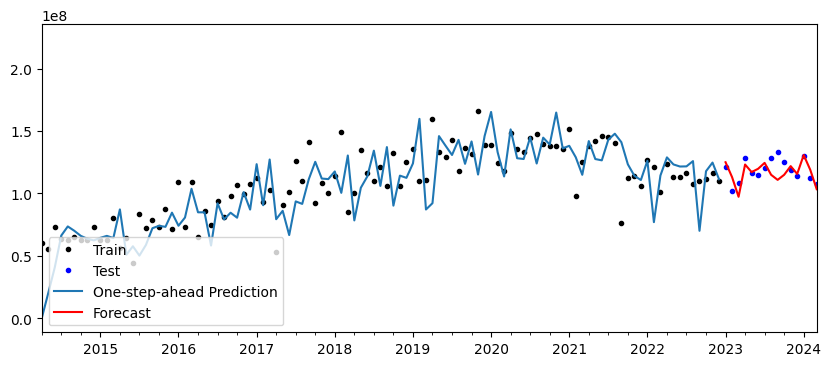

In [944]:
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
ssm_train['y'].plot(ax=ax, style='k.', label='Train')
ssm_test['y'].plot(ax=ax, style='b.', label='Test')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='lower left');


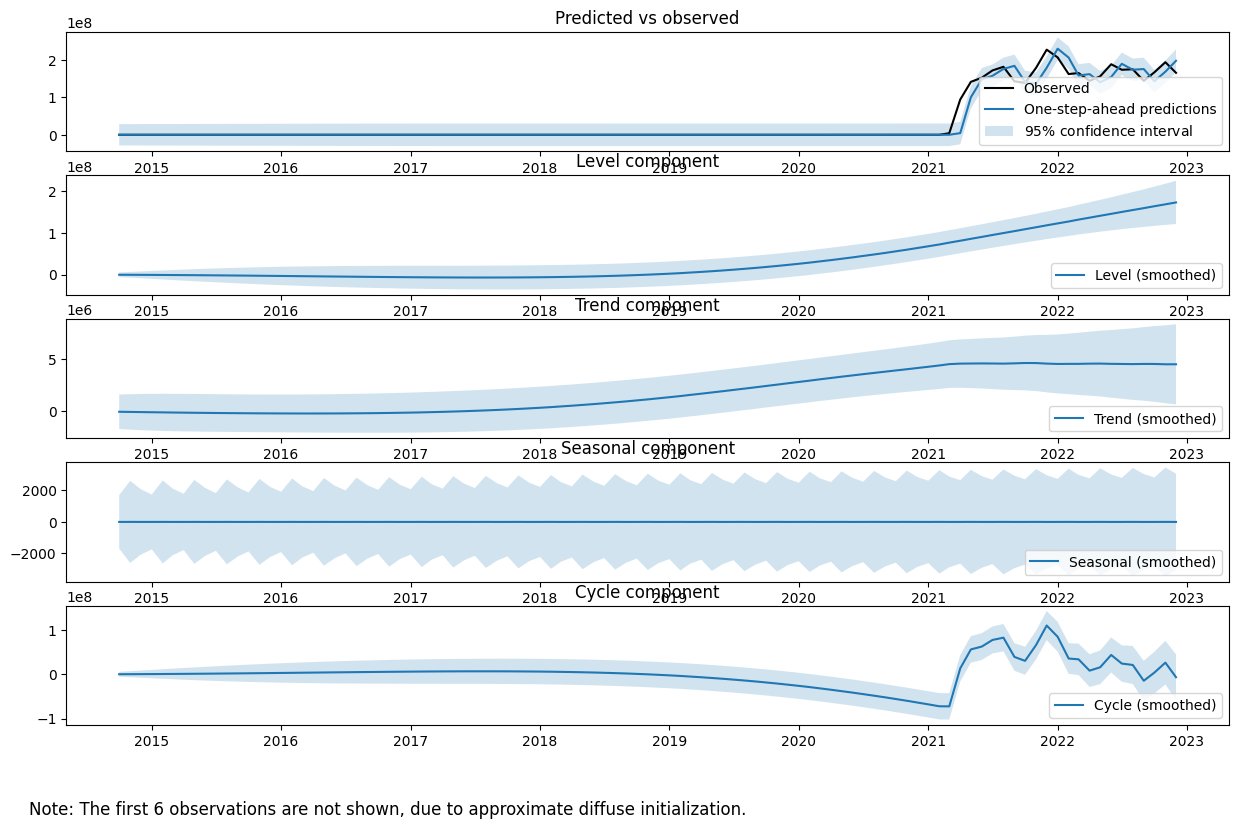

In [ ]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

# **PARAMETER OPTIMIZATION**

In [48]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import product

def optimize_uc_model(data_train, data_test):
    # Seasonal and autoregressive
    seasonal_values = [3, 6, 12, 18]
    ar_values = [None]  # Updated to include None
    level_values = [1]

    # Define all possible values for each boolean parameter
    boolean_params = [0, 1]

    # Create all combinations of parameters
    all_combinations = list(product(boolean_params, range(len(ar_values)), level_values, boolean_params,
                                    boolean_params, boolean_params, boolean_params, boolean_params,
                                    boolean_params, seasonal_values, boolean_params))

    best_error = float('inf')
    best_params = None

    # Iterate over all combinations
    for combo in all_combinations:
        model_params = {
            'irregular': bool(combo[0]),
            'autoregressive': ar_values[combo[1]],  # Use index to fetch correct value, including None
            'level': bool(combo[2]),
            'stochastic_level': bool(combo[3]),
            'trend': bool(combo[4]),
            'stochastic_trend': bool(combo[5]),
            'cycle': bool(combo[6]),
            'damped_cycle': bool(combo[7]),
            'stochastic_cycle': bool(combo[8]),
            'seasonal': combo[9],
            'stochastic_seasonal': bool(combo[10])
        }

        try:
            # Fit the model
            mod = sm.tsa.UnobservedComponents(data_train['y'], **model_params)
            res = mod.fit(method='powell', disp=False)

            # Forecasting
            forecast = res.get_forecast(steps=len(data_test))
            forecast_values = forecast.predicted_mean

            actuals = data_test['y'].sum()
            forecasted = forecast_values.sum()

            # Calculate error
            error = ((forecasted - actuals) / actuals) * 100

            # Store the best parameters
            if np.abs(error) < np.abs(best_error):
                best_error = error
                best_params = model_params
                print(f"New best error: {best_error} with params: {best_params}")
        except Exception as e:
            print(f"An error occurred with params {model_params}: {e}")

    return best_params, best_error


combinations = [
    {'product2test': 'TACROLIMUS - Tacrolimus', 'lv52test': 'D_E_NETHLND - Netherlands'},
    {'product2test': 'TAMSULOSIN - Tamsulosin HCl', 'lv52test': 'D_E_SWITZ - Switzerland'},
    {'product2test': 'TACROLIMUS - Tacrolimus', 'lv52test': 'JP10 - Astellas Pharma Inc'},
    {'product2test': 'MIRABEGRON - Mirabegron', 'lv52test': 'D_E_NETHLND - Netherlands'},
    {'product2test': 'MIRABEGRON - Mirabegron', 'lv52test': 'D_E_IE - Ireland'},
    {'product2test': 'QUETIAPINE - QUETIAPINE', 'lv52test': 'JP10 - Astellas Pharma Inc'},
    {'product2test': 'TAMSUL_TAB - Tamsulosin tab', 'lv52test': 'D_E_RO - Romania'},
    {'product2test': 'TACROLIMUS - Tacrolimus', 'lv52test': 'D_E_SWITZ - Switzerland'},
    {'product2test': 'GILTERITNB - Gilteritinib', 'lv52test': 'D_E_SWITZ - Switzerland'},
    {'product2test': 'TACROLIMUS - Tacrolimus', 'lv52test': 'D_E_GB - Great Britain'}
]

# DataFrame to store results
results_df = pd.DataFrame(columns=['Product', 'Market', 'Optimal Parameters', 'Minimum Error'])

# Loop over each combination
for combo in combinations:
    product2test = combo['product2test']
    lv52test = combo['lv52test']

    # Fetch unique ID for the current combination
    id2test = volume_act[(volume_act['ProductLv'] == product2test) & (volume_act['Lv5'] == lv52test)]['unique_id'].unique()[0]

    # Filter and prepare data
    ssm_data = volume_act[volume_act['unique_id'] == id2test]
    ssm_data = ssm_data[['ds', 'y']]
    ssm_data = ssm_data.set_index('ds')
    ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

    # Split data into training and testing sets
    ssm_test = ssm_data.tail(fct_periods)
    ssm_train = ssm_data.drop(ssm_test.index)

    # Run optimization
    best_params, minimum_error = optimize_uc_model(ssm_train, ssm_test)

    # Create a DataFrame for the current results
    current_result = pd.DataFrame({
        'Product': [product2test],
        'Market': [lv52test],
        'Optimal Parameters': [best_params],
        'Minimum Error': [minimum_error]
    })

    # Append results to the main results DataFrame
    results_df = pd.concat([results_df, current_result], ignore_index=True)

SyntaxError: invalid syntax (<ipython-input-48-da013c7e9969>, line 67)

In [ ]:
results_df

# **BULK RUN**

In [ ]:
def forecast_error(df, volume_act, fct_periods, fct_st_date):
    # Initialize the output DataFrame
    results = pd.DataFrame(columns=['id2test', 'Product', 'Lv5', 'actuals_fy23', 'forecast_fy23', 'error'])

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        product = row['Product']
        Lv5 = row['Lv5']
        model_settings = row.drop(['Product', 'Lv5']).to_dict()
        print(product)
        print(Lv5)
        # Determine unique ID based on product and Lv5
        id2test = volume_act[(volume_act['ProductLv'] == product) & (volume_act['Lv5'] == Lv5)]['unique_id'].unique()[0]

        # Filter the data for this specific ID
        ssm_data = volume_act[volume_act['unique_id'] == id2test]
        ssm_data = ssm_data[['ds', 'y']]
        ssm_data = ssm_data.set_index('ds')
        ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

        # Set train and test period
        ssm_test = ssm_data.tail(fct_periods)
        ssm_train = ssm_data.drop(ssm_test.index)

        # Fit the model
        mod = sm.tsa.UnobservedComponents(ssm_train['y'], **model_settings)
        res = mod.fit(method='powell', disp=False)

        # Perform prediction and forecasting
        predict = res.get_prediction()
        forecast = res.get_forecast('2024-03-01')

        actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
        forecast_fy23 = forecast.predicted_mean.loc[forecast.predicted_mean.index >= fct_st_date].sum()

        error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100

        new_row = pd.DataFrame({
            'id2test': [id2test],
            'Product': [product],
            'Lv5': [Lv5],
            'actuals_fy23': [actuals_fy23],
            'forecast_fy23': [forecast_fy23],
            'error': [error]
        })

        # Using concat to append the new row
        results = pd.concat([results, new_row], ignore_index=True)

    return results

In [ ]:
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings.csv'
unrestricted_model_settings = pd.read_csv(inputFile, dtype={'autoregressive': 'Int64'})

unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['LostinOrig']==1) & (unrestricted_model_settings['Success']!=1)]

unrestricted_model_settings = unrestricted_model_settings.drop(['Success', 'LostinOrig', '%ofSales'], axis=1)

In [945]:
# Assuming 'budget' is your DataFrame
grouped_budget = budget.groupby(['unique_id'])['y'].sum().reset_index()
grouped_budget.columns=['id2test', 'budget_fy23']

# Calculate the number of chunks
num_rows = len(unrestricted_model_settings)
chunk_size = 10  # Process 5 rows at a time
num_chunks = (num_rows // chunk_size) + (1 if num_rows % chunk_size else 0)

start_chunk = 6
num_chunks = 6

# Loop through each chunk
for i in range(start_chunk - 1, num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size

    # Get the subset of the DataFrame
    subset = unrestricted_model_settings.iloc[start_index:end_index]

    # Check if the subset is empty (this might occur if your total rows are exactly divisible by the chunk size)
    if subset.empty:
        break

    # Run the function
    results_df = forecast_error(subset, volume_act, fct_periods, fct_st_date)

    # Display the grouped and summed DataFrame
    results2comp = results_df.merge(grouped_budget, how='left', on='id2test')
    results2comp['bud_error'] = ((results2comp['budget_fy23'] - results2comp['actuals_fy23']) / results2comp['actuals_fy23']) * 100
    results2comp['winner'] = np.where(np.abs(results2comp['error']) < np.abs(results2comp['bud_error']), 'Dx', 'Bud')
    results2comp = results2comp[['winner','Lv5', 'Product', 'actuals_fy23', 'forecast_fy23', 'budget_fy23', 'error', 'bud_error', 'id2test']]

    # # Save the output to a CSV file, naming them uniquely
    # results2comp.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/results/Blind Test FY23/results_chunk_{i+1}.csv', index=False)

results2comp

TACROLIMUS - Tacrolimus
D_E_NETHLND - Netherlands
TACROLIMUS - Tacrolimus
D_E_SWITZ - Switzerland
TAMSULOSIN - Tamsulosin HCl
JP10 - Astellas Pharma Inc
MIRABEGRON - Mirabegron
D_E_NETHLND - Netherlands
TACRO_XL - Tacrolimus Extended-Release
D_E_SWITZ - Switzerland
ENZA - Enzalutamide
D_E_SLVNA - Slovenia
MIRABEGRON - Mirabegron
D_E_IE - Ireland
QUETIAPINE - QUETIAPINE
JP10 - Astellas Pharma Inc
TAMSUL_TAB - Tamsulosin tab
D_E_RO - Romania
GILTERITNB - Gilteritinib
D_E_GB - Great Britain


,winner,Lv5,Product,actuals_fy23,forecast_fy23,budget_fy23,error,bud_error,id2test
0,Bud,D_E_NETHLND - Netherlands,TACROLIMUS - Tacrolimus,"1,433,293,122.68","483,145,493.20","1,205,396,233.49",-66.29,-15.90,Global/TACROLIMUS - Tacrolimus/D_E_ESTMKT - Es...
1,Bud,D_E_SWITZ - Switzerland,TACROLIMUS - Tacrolimus,"1,345,112,549.75","1,711,095,492.61","1,497,633,088.42",27.21,11.34,Global/TACROLIMUS - Tacrolimus/D_E_ESTMKT - Es...
2,Bud,JP10 - Astellas Pharma Inc,TAMSULOSIN - Tamsulosin HCl,"1,310,310,576.00","2,598,292,528.96","1,277,221,000.83",98.30,-2.53,Global/TAMSULOSIN - Tamsulosin HCl/D_JPCOM - J...
3,Bud,D_E_NETHLND - Netherlands,MIRABEGRON - Mirabegron,"1,293,929,337.22","1,434,819,703.73","1,343,092,711.65",10.89,3.80,Global/MIRABEGRON - Mirabegron/D_E_ESTMKT - Es...
4,Dx,D_E_SWITZ - Switzerland,TACRO_XL - Tacrolimus Extended-Release,"1,287,952,168.63","1,192,382,913.71","1,067,659,256.73",-7.42,-17.10,Global/TACRO_XL - Tacrolimus Extended-Release/...
5,Dx,D_E_SLVNA - Slovenia,ENZA - Enzalutamide,"1,272,200,941.57","1,128,449,467.46","1,080,803,688.70",-11.30,-15.04,Global/ENZA - Enzalutamide/D_E_ESTMKT - Establ...
6,Bud,D_E_IE - Ireland,MIRABEGRON - Mirabegron,"1,214,203,713.93","920,966,105.18","1,206,618,180.43",-24.15,-0.62,Global/MIRABEGRON - Mirabegron/D_E_ESTMKT - Es...
7,Bud,JP10 - Astellas Pharma Inc,QUETIAPINE - QUETIAPINE,"1,129,900,888.00","935,553,909.11","949,085,003.31",-17.20,-16.00,Global/QUETIAPINE - QUETIAPINE/D_JPCOM - Japan...
8,Bud,D_E_RO - Romania,TAMSUL_TAB - Tamsulosin tab,"1,084,618,327.71","879,669,573.32","939,593,917.65",-18.90,-13.37,Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT ...
9,Bud,D_E_GB - Great Britain,GILTERITNB - Gilteritinib,"1,080,265,099.70","581,302,521.20","1,198,452,558.52",-46.19,10.94,Global/GILTERITNB - Gilteritinib/D_E_ESTMKT - ...
